# Loading training Data

In [2]:
import numpy as np
import pandas as pd

df=pd.read_csv('train_x.csv').set_index('ID')
dfy=pd.read_csv('train_y.csv').set_index('ID')
df['Label']=dfy['Label']

# Label encoding for Loan type and Occupation type :
df['Loan type1']=[0 if i=='A' else 1 if  i=='B' else np.nan for i in df['Loan type']  ]
df['Occupation type1']=[0 if i=='X' else 1 if i=='Y' else 2 if i=='Z' else np.nan for i in df['Occupation type']]
df=df.drop(['Loan type','Occupation type'],axis=1)

# Imputing missing values using K-nearest neighbours

In [3]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10, weights="uniform")
array=imputer.fit_transform(df)
dfimputed=pd.DataFrame(array,columns=df.columns)
# For categorical variables , imputed values will be decimals so, converting them to their corresponding integers.
dfimputed['Occupation type1']=[0 if i<(2/3) else 1 if ((2/3)<=i<(4/3)) else 2 for i in dfimputed['Occupation type1']]
dfimputed['Age']=[0 if i<0.5 else 1 for i in dfimputed['Age']]
dfimputed['Loan type1']=[0 if i<0.5 else 1 for i in dfimputed['Loan type1']]
y=dfimputed['Label'].astype(int)
X=dfimputed.drop(['Label'],axis=1)

# Test , train split

In [4]:
from sklearn.model_selection import train_test_split
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

# XGBoost classifier 

In [5]:
from xgboost import XGBClassifier
# Using random states to reproduce results
rng = 2
clf_xgb = XGBClassifier(eval_metric='error',use_label_encoder=False,random_state = rng)

# K-fold cross validation

In [6]:
from sklearn.model_selection import RepeatedStratifiedKFold
# Repeated stratified K fold for imbalanced classification
numFolds = 5
kfold_5 = RepeatedStratifiedKFold(n_repeats=3,n_splits = numFolds,random_state=rng)

# Positive to negative class ratio

In [7]:

positive_to_negative_ratio=(len(y)-int(y.sum()))/(y.sum())
print(positive_to_negative_ratio)

14.891934843067144


# Randomized Search for best model

In [8]:
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
# Using probability distributions to get randomized parameters in intervals.
param_dist = {  'max_depth': [3, 4, 5, 6, 7, 8, 9],# Varying maximum depth on a tree
                'learning_rate': stats.uniform(0.01, 0.6),# Step size shrinkage used in update to prevents overfitting
                'n_estimators': stats.randint(150, 1000),# No of trees in a model
                'gamma': [0, 0.1, 0.2],# Minimum loss reduction required to make a further partition on a leaf node of the tree.
                'min_child_weight': [0.5*r for r in range(9)], # Minimum sum of instance weight (hessian) needed in a child
                'subsample': stats.uniform(0.3, 0.9),
                'colsample_bytree': stats.uniform(0, 0.9),# Subsampling of columns in rach tree
                'colsample_bylevel': [1],# Subsampling of columns
                'reg_alpha': [0, 1e-2, 1, 1e1],# L2 regularization term on weights
                'reg_lambda': [0, 1e-2, 1, 1e1], # L1 regularization term on weights
                'base_score': [0.5],# The initial prediction score of all instances, global bias
                'scale_pos_weight':[13,14,15,16] # (For imbalanced data - positive to negative class >10 )scale_pos_weight is the ratio of number of negative class to the positive class
             }
# Because the parameter grid is big, randomized search used for lesser time
clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 5, 
                         scoring = 'roc_auc',  # scoring models on roc_auc
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1,
                        random_state = rng)

# Fitting trained model

In [9]:
clf.fit(X_train,y_train)
print(clf.cv_results_)

Fitting 15 folds for each of 5 candidates, totalling 75 fits


c:\Users\sanju\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sanju\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sanju\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\sanju\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File "c:\Users\sanju\ana

{'mean_fit_time': array([ 5.41969512, 10.50733825,  7.2429033 ,  6.70270054,  0.31562675]), 'std_fit_time': array([0.40060209, 0.58722854, 0.37068272, 0.30508129, 0.03838712]), 'mean_score_time': array([0.26616459, 0.59601054, 0.44150985, 0.51989948, 0.        ]), 'std_score_time': array([0.04403155, 0.05967349, 0.08496951, 0.14618267, 0.        ]), 'param_base_score': masked_array(data=[0.5, 0.5, 0.5, 0.5, 0.5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_colsample_bylevel': masked_array(data=[1, 1, 1, 1, 1],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_colsample_bytree': masked_array(data=[0.3923954119278034, 0.6289764222304811,
                   0.6477788091212632, 0.3853100948376505,
                   0.15104097963131016],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked

# Training data performance

In [10]:
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,roc_auc_score
roc_auc_score(y_train,clf.predict(X_train))

0.9966852478598447

# Metrics for prediction of test data

In [11]:
pred_test = clf.predict(X_test)
predictions = [round(value) for value in pred_test]
print('Accuracy is:',accuracy_score(y_test,predictions))
print('F1 score is:',f1_score(y_test,predictions))
print('Precision score is:',precision_score(y_test,predictions))
print('ROC AUC score is:',roc_auc_score(y_test,predictions))
print('Recall score is:',recall_score(y_test,predictions))

Accuracy is: 0.978560606060606
F1 score is: 0.8348891481913653
Precision score is: 0.8112244897959183
ROC AUC score is: 0.9232569005622451
Recall score is: 0.8599759615384616


# Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

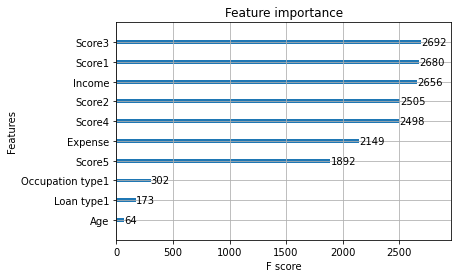

In [11]:
from xgboost import plot_importance

plot_importance(clf.best_estimator_)

# Prediction of test_x

In [12]:
test_x=pd.read_csv("test_x.csv").set_index('ID_Test')
test_x['Loan type1']=[0 if i=='A' else 1 if  i=='B' else np.nan for i in test_x['Loan type']  ]
test_x['Occupation type1']=[0 if i=='X' else 1 if i=='Y' else 2 if i=='Z' else np.nan for i in test_x['Occupation type']]
test_x=test_x.drop(['Loan type','Occupation type'],axis=1)
pred_arr=pd.DataFrame(clf.predict(test_x),index=test_x.index).rename(columns={0:'Label'})
pred_arr.to_csv('pred_y.csv')